In [46]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import word2vec
import matplotlib.pyplot as plt
%matplotlib inline
import umap
import warnings;
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('products.csv',index_col=[0])
df.head()

,client,timestamp,product_id
208,85ab8f53-b934-49dd-8d54-479ed08499f6,2021-08-29 17:05:45.368000+00:00,63594
209,85ab8f53-b934-49dd-8d54-479ed08499f6,2021-08-29 17:07:02.711000+00:00,63290
210,85ab8f53-b934-49dd-8d54-479ed08499f6,2021-08-29 17:08:51.306000+00:00,64872
247,46989f50-87f9-4ece-9db3-cffaa3bf2278,2021-08-29 19:23:07.176000+00:00,63593
1665,dbbcd1c1-c0ca-4eed-b144-736fc40f6d24,2021-08-29 20:00:40.706000+00:00,56093


In [56]:
# işlem yapılacak veri sayısını verir.
df.shape

(323614, 3)

In [57]:
# eksik değerleri kontrol eder.
df.isnull().sum()

client        0
timestamp     0
product_id    0
dtype: int64

In [58]:
# eksik olan değerleri kaldırır.
df.dropna(inplace=True)
df['product_id']= df['product_id'].astype(str)

In [59]:
#veri setindeki benzersiz müşteri sayısını kontrol eder
customers = df["client"].unique().tolist()
len(customers)

27799

In [61]:
# müşteri Id'lerini karıştırır
random.shuffle(customers)

# müşteri Id'lerinin %90'ını çıkarır.
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# verileri train ve validationa ayırır.
train_df = df[df['client'].isin(customers_train)]
validation_df = df[~df['client'].isin(customers_train)]

In [62]:
# müşterilerin satın alma geçmişini yakalamak için liste
purchases_train = []

# listeyi ürün kodlarıyla doldurur
for i in tqdm(customers_train):
    temp = train_df[train_df["client"] == i]["product_id"].tolist()
    purchases_train.append(temp)

100%|██████████| 25019/25019 [17:42<00:00, 23.55it/s]


In [63]:
# müşterilerin satın alma geçmişini yakalamak için liste
purchases_val = []

# listeyi ürün kodlarıyla doldurur
for i in tqdm(validation_df['client'].unique()):
    temp = validation_df[validation_df["client"] == i]["product_id"].tolist()
    purchases_val.append(temp)

100%|██████████| 2780/2780 [00:16<00:00, 169.74it/s]


In [64]:
# train word2vec model
model =   word2vec.Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)



(1891873, 2914180)

In [65]:
#modeli bellek için daha verimli hale getirir.
model.init_sims(replace=True)

In [66]:
#model özetini verir.
print(model)

Word2Vec<vocab=11177, vector_size=100, alpha=0.03>


In [67]:
#tüm vektörleri çıkarır
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
X.shape


(11177, 100)

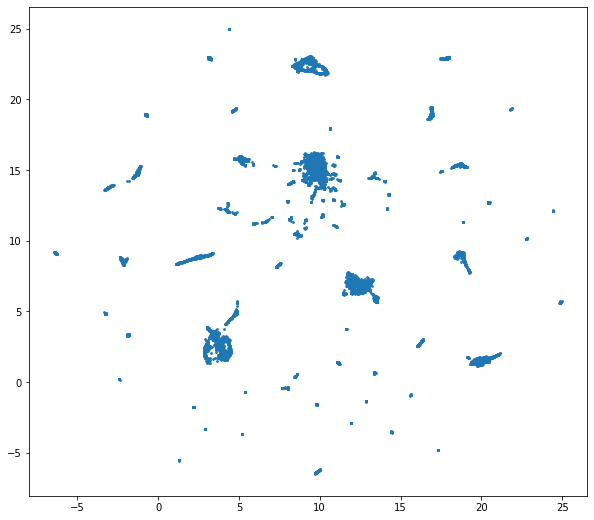

In [68]:
#Word2Vec gömmelerini görselleştirir.
import umap.umap_ as umap
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [69]:
products = train_df[["product_id", "client"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='product_id', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('product_id')['client'].apply(list).to_dict()

In [70]:
# test the dictionary
products_dict['746882']

['0f526a95-cff0-46cc-ad77-906f86ff1e9a']

In [71]:
def similar_products(v, n):
    
    # extract most similar products for the input vector
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

In [72]:
#tek bir ürün vektörüne göre benzer ürün önerme
model.wv.most_similar('746882')

[('1001335', 0.970515251159668),
 ('102965772', 0.9500181078910828),
 ('69716997', 0.9435670375823975),
 ('70251457', 0.9394763112068176),
 ('639638', 0.9362722039222717),
 ('639637', 0.9289524555206299),
 ('994564', 0.9052689671516418),
 ('880887', 0.9024561643600464),
 ('973081', 0.8942194581031799),
 ('42675622', 0.876154363155365)]

In [77]:
#geçmiş satın alma işlemine göre önerme
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [78]:
#Bir kullanıcı tarafından satın alınan ürünlerin ilk listesinin uzunluğu
len(purchases_val[0])

12

In [79]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [80]:
#sistemimiz bir kullanıcının tüm satın alma geçmişine dayalı olarak 6 ürün önerdi.
similar_products(aggregate_vectors(purchases_val[0]),6)

[('9cbeb70d-8459-4a3f-ac80-572eac6c6c06', 0.9482565522193909),
 ('ff31e26a-4fef-425f-97c2-5456f08945fe', 0.9474012851715088),
 ('e86e8778-d4e6-40ad-972f-6a39aba015f4', 0.9124858379364014),
 ('f28730a8-4e36-47c4-a79b-1d2d1b7fe051', 0.8959090709686279),
 ('eda1bea6-9130-463f-a765-fc891ba3f794', 0.8825235366821289),
 ('ae48f5cf-b18e-4b14-ba4f-6b88e700fd4f', 0.8749083876609802)]

In [81]:
#satın alınan son 10 ürün
similar_products(aggregate_vectors(purchases_val[0][-10:]),6)

[('9cbeb70d-8459-4a3f-ac80-572eac6c6c06', 0.954931378364563),
 ('ff31e26a-4fef-425f-97c2-5456f08945fe', 0.9359538555145264),
 ('e86e8778-d4e6-40ad-972f-6a39aba015f4', 0.915549635887146),
 ('f28730a8-4e36-47c4-a79b-1d2d1b7fe051', 0.8991554975509644),
 ('eda1bea6-9130-463f-a765-fc891ba3f794', 0.8835961818695068),
 ('ae48f5cf-b18e-4b14-ba4f-6b88e700fd4f', 0.879575788974762)]